<a href="https://colab.research.google.com/github/lmcarboneau/GP-systematics/blob/master/modelling/linear_systematic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tfmodel = keras.models.load_model('./drive/My Drive/Colab Notebooks/test_grid_model.h5')

In [4]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [5]:
weights_list = tfmodel.get_weights()

In [6]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [7]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [8]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [18]:
Nstars = 10
ages = np.random.rand(Nstars) * 3.0 + 2.0
masses = np.random.rand(Nstars) * 0.05 + 1.0
inputs = np.array([ages, masses]).T
outputs = nn(np.log10(inputs)).eval()

In [19]:
outputs

array([[1.10847869e+00, 6.33256463e+03, 1.16173575e+02],
       [1.13044382e+00, 6.61667512e+03, 1.13615016e+02],
       [1.15737701e+00, 6.03496529e+03, 1.11968879e+02],
       [1.18914114e+00, 6.02947869e+03, 1.08844143e+02],
       [1.14583895e+00, 6.33192406e+03, 1.12191801e+02],
       [1.10551761e+00, 6.40495062e+03, 1.16386410e+02],
       [1.13599407e+00, 6.37768239e+03, 1.13109830e+02],
       [1.09612357e+00, 6.67609518e+03, 1.18010921e+02],
       [1.15641523e+00, 6.24246884e+03, 1.11348226e+02],
       [1.18051789e+00, 6.02118148e+03, 1.09715143e+02]])

In [26]:
obs_unc = np.array([[0.01, 70.0, 1.0] for n in range(Nstars)])
obs_ = outputs + np.random.randn(*outputs.shape) * obs_unc 
obs_[:,2] += (outputs[:,2] - 115 ) * 0.1 
print(obs_.shape)

(10, 3)


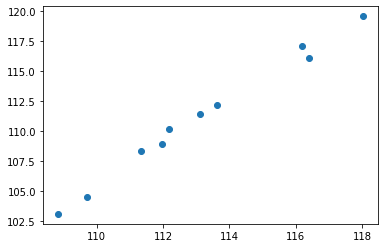

In [24]:
plt.scatter(outputs[:,2], obs_[:,2])

In [27]:
model = pm.Model()
#X = obs_[:, 2][:, None]

with model:
    mass = pm.Normal('mass', 1.0, 0.2, shape=Nstars)
    age = pm.Normal('age', 4.5, 3.0, shape=Nstars)
    
    slist = [[T.log10(age[m]), T.log10(mass[m])] for m in range(Nstars)]
    obs_prop = pm.Deterministic('obs_prop', nn(T.stacklists(slist)))
    
    like_r = pm.Normal('like_r', obs_prop[:, 0], obs_unc[:, 0], observed=obs_[:, 0])
    like_t = pm.Normal('like_t', obs_prop[:, 1], obs_unc[:, 1], observed=obs_[:, 1])
    y = obs_prop[:, 2] - obs_[:, 2]
    X = obs_prop[:, 2][:, None]

    cov_func = 1.0**2 * pm.gp.cov.ExpQuad(1, ls=30)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood('y_', X=X, y=y, noise=obs_unc[:, 2])

In [28]:
inits = ['adapt_diag']
start = {'mass': [1.0 for n in range(Nstars)], 'age': [4.5 for n in range(Nstars)]}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [age, mass]
100%|██████████| 1500/1500 [00:22<00:00, 67.18it/s]


In [ ]:
#pm.traceplot(trace);

In [ ]:
#pm.summary(trace)

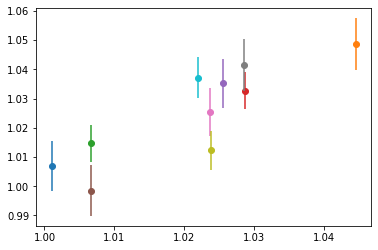

In [29]:
fig, ax = plt.subplots()#dpi=300)
for idx, i in enumerate(masses):
  ax.scatter(i, np.mean(trace['mass'][:, idx]))
  ax.errorbar(i, np.mean(trace['mass'][:, idx]), yerr=np.std(trace['mass'][:, idx]))

In [30]:
Xnew = np.linspace(40, 150, 200)[:, None]

with model:
  f_star = gp.conditional('f_star', Xnew=Xnew)

with model:
  pred_samples = pm.sample_posterior_predictive(trace, vars=[f_star], samples=2000)

100%|██████████| 2000/2000 [06:03<00:00,  5.50it/s]


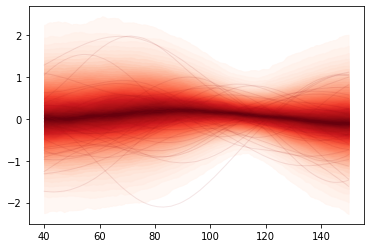

In [32]:
fig = plt.figure()#dpi=300); 
ax = fig.gca()

from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_star"], Xnew);